# Problem: Deconvolution

### example

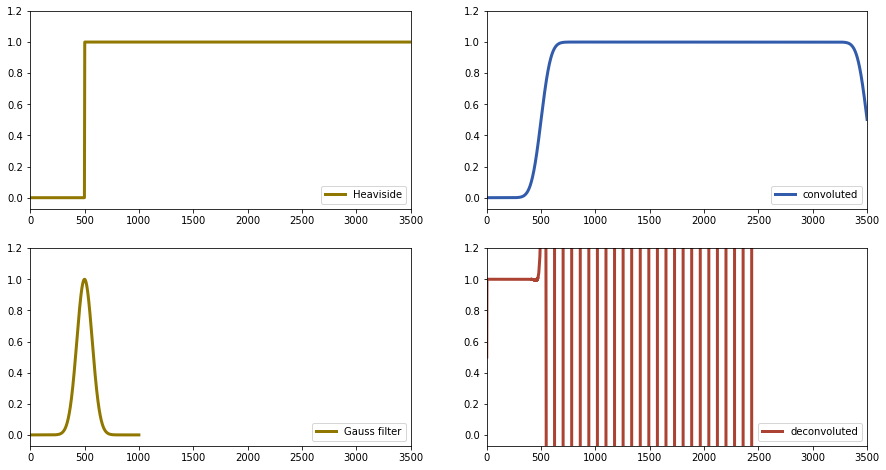

In [1]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

# Define heaviside function
H = lambda x: 0.5 * (np.sign(x) + 1.)
#define gaussian
gauss = lambda x, sig: np.exp(-( x/float(sig))**2 )

X = np.linspace(-5, 30, num=3501)
X2 = np.linspace(-5,5, num=1001)

# convolute a heaviside with a gaussian
H_c = np.convolve( H(X),  gauss(X2, 1),  mode="same"  )
# deconvolute a the result
H_dc, er = scipy.signal.deconvolve(H_c, gauss(X2, 1) )


#### Plot #### 
fig , ax = plt.subplots(2, 2, figsize=(15,8))
ax[0,0].plot( H(X),          color="#907700", label="Heaviside",    lw=3 ) 
ax[1,0].plot( gauss(X2, 1),  color="#907700", label="Gauss filter", lw=3 )
ax[0,1].plot( H_c/H_c.max(), color="#325cab", label="convoluted" ,  lw=3 ) 
ax[1,1].plot( H_dc,          color="#ab4232", label="deconvoluted", lw=3 ) 
for axs in ax:
    for a in axs:
        a.set_xlim([0, len(X)])
        a.set_ylim([-0.07, 1.2])
        a.legend(loc=4)
plt.show()

- The filter should be much bigger than zero everywhere (0.013 is good enough)
- Using the keyword argument mode = 'same' to the convolution ensures that it lives on the same array shape as the signal.
- The deconvolution has n = len(signal) - len(gauss) + 1 points. So in order to let it also reside on the same original array shape we need to expand it by s = (len(signal)-n)/2 on both sides.

### Solution 1: 

0.013032907448509346


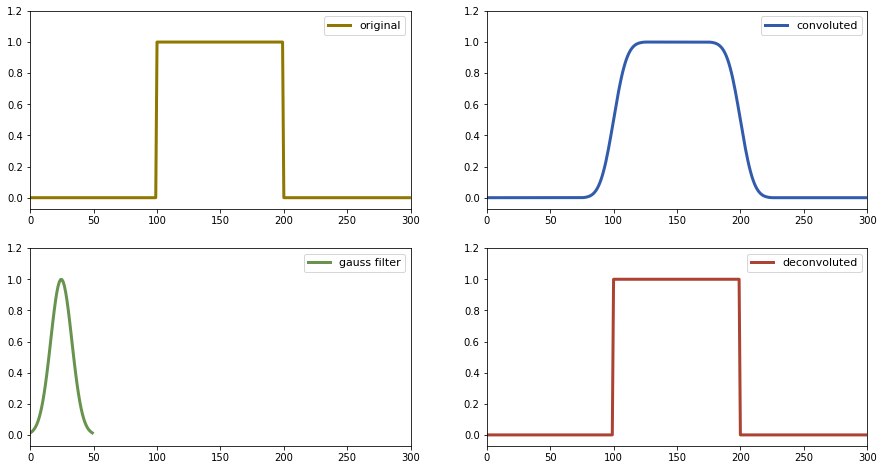

In [2]:
signal = np.repeat([0., 1., 0.], 100)
# and use a gaussian filter
# the filter should be such that it's much bigger then zero everywhere
gauss = np.exp(-( (np.linspace(0,50)-25.)/float(12))**2 )
print(gauss.min())  # = 0.013 >> 0

# the keywordargument mode="same" ensures that the convolution spans the same shape as the input array.
filtered = scipy.signal.convolve(signal, gauss, mode='same') 
#filtered = np.convolve(signal, gauss, mode='same') 

deconv,  _ = scipy.signal.deconvolve( filtered, gauss )
#the deconvolution has n = len(signal) - len(gauss) + 1 points
n = len(signal)-len(gauss)+1
# so we need to expand it by 
s = round((len(signal)-n)/2)
#on both sides.
deconv_res = np.zeros(len(signal))
deconv_res[s:len(signal)-s-1] = deconv
deconv = deconv_res
# now deconv contains the deconvolution 
# expanded to the original shape (filled with zeros) 


#### Plot #### 
fig , ax = plt.subplots(2, 2, figsize=(15,8))

ax[0,0].plot(signal, color="#907700", label="original", lw=3 ) 
ax[1,0].plot(gauss, color="#68934e", label="gauss filter", lw=3 )
# we need to divide by the sum of the filter window to get the convolution normalized to 1
ax[0,1].plot(filtered/np.sum(gauss), color="#325cab", label="convoluted" , lw=3 )
ax[1,1].plot(deconv,color="#ab4232", label="deconvoluted", lw=3 ) 

for a in ax:
    for i in range(len(ax)):
        a[i].set_xlim([0, len(signal)])
        a[i].set_ylim([-0.07, 1.2])
        a[i].legend(loc=1, fontsize=11)

### Problem with this solution:

- Would need to change values in th HRF signal generated by SPM
- Deconvolution needs to be padded with zeros to obtain original shape $\rightarrow$ doesn't work for non-zero edges

### Solution 2: implement convolution with matrices 

http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/signal/convmtx.html

In [64]:
from scipy.stats import gamma
from math import floor, ceil
from numpy.linalg import pinv

def spm_Gpdf(x, α, β):
    return gamma(a=α, scale=1/β).pdf(x)

def spm_hrf(RT):
    p = np.array([6., 16., 1., 1., 6., 0., 32.])
    fMRI_T = 16
    
    dt = RT / fMRI_T
    u = np.arange(0, ceil(p[6]/dt)) - (p[5]/dt)
    
    hrf = spm_Gpdf(u, p[0]/p[2], dt/p[2]) - spm_Gpdf(u, p[1]/p[3], dt/p[3])/p[4]
    hrf = hrf[np.arange(0, floor(p[6]/RT))*fMRI_T + 1]
    return hrf/np.sum(hrf)

def getConvolutionMatrix(u: np.array, v: np.array):
    m = u.shape[0]
    n = v.shape[0]
    matrix = np.zeros((n, m+n-1))
    for i in range(0, n):
        matrix[i, i:(m+i)] = u
    return matrix

def getDeconvolutionMatrix(u: np.array, v: np.array):
    m = u.shape[0]
    n = v.shape[0]
    mat = getConvolutionMatrix(u, np.zeros(n-m+1))
    return pinv(mat)

hrf_signal = spm_hrf(1.3)

signal = np.zeros((275, 3))

signal[21:30,0] = 1
signal[51:60,0] = 1
signal[81:90,0] = 1
signal[111:120,0] = 1
signal[151:160,0] = 1

signal[36:45,1] = 1
signal[66:75,1] = 1
signal[96:105,1] = 1
signal[126:135,1] = 1
signal[166:175,1] = 1

signal[201:210,2] = 1
signal[241:260,2] = 1

signal += 1

convmat = getConvolutionMatrix(hrf_signal, signal)
convsignal = np.zeros((len(convmat.T), len(signal.T)))

for i in range(0, len(signal.T)):
    convsignal[:, i] = convmat.T @ signal[:, i]
    
deconv_mat = getDeconvolutionMatrix(hrf_signal, convsignal)
deconv_signal = np.zeros((len(deconv_mat.T), len(signal.T)))
for i in range(0, len(signal.T)):
    deconv_signal[:, i] = deconv_mat.T @ convsignal[:, i]

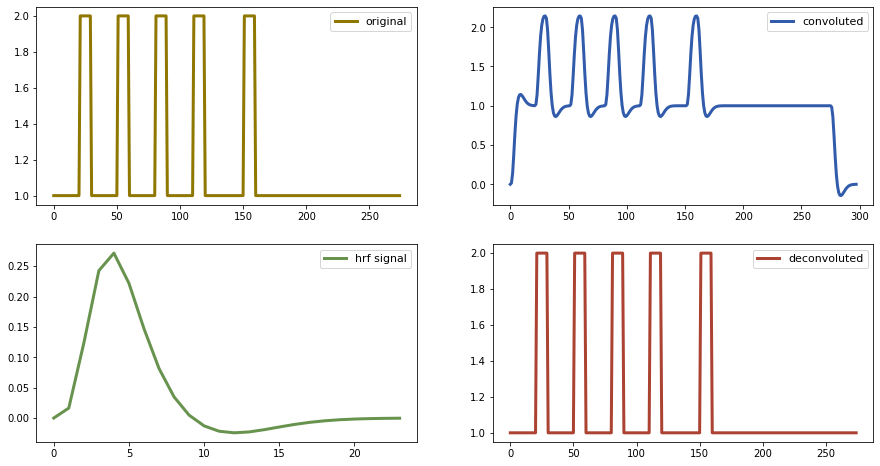

In [65]:
#### Plot #### 
fig , ax = plt.subplots(2, 2, figsize=(15,8))

ax[0,0].plot(signal[:,0], color="#907700", label="original", lw=3 ) 
ax[1,0].plot(hrf_signal, color="#68934e", label="hrf signal", lw=3 )
# we need to divide by the sum of the filter window to get the convolution normalized to 1
ax[0,1].plot(convsignal[:,0], color="#325cab", label="convoluted" , lw=3 )
ax[1,1].plot(deconv_signal[:,0],color="#ab4232", label="deconvoluted", lw=3 ) 

for a in ax:
    for i in range(len(ax)):
        #a[i].set_xlim([0, len(signal)])
        #a[i].set_ylim([-0.07, 1.2])
        a[i].legend(loc=1, fontsize=11)

In [66]:
hrf_signal = spm_hrf(0.3)

deconv_mat = getDeconvolutionMatrix(hrf_signal, np.zeros(150))
deconv_signal = np.zeros((len(deconv_mat.T), len(signal.T)))
for i in range(0, len(signal.T)):
    deconv_signal[:, i] = deconv_mat.T @ convsignal[50:200, i]

In [67]:
scipy_signal_full = scipy.signal.convolve(signal[:, 0], hrf_signal, mode='full')
scipy_signal_valid = scipy.signal.convolve(signal[:, 0], hrf_signal, mode='valid')
scipy_signal_same = scipy.signal.convolve(signal[:, 0], hrf_signal, mode='same')

In [7]:
hrf_signal.shape

(17,)

In [8]:
scipy_signal_full.shape

(291,)

In [9]:
scipy_signal_valid.shape

(259,)

In [10]:
scipy_signal_same.shape

(275,)

In [11]:
hrf_signal = spm_hrf(1.8)
signal = np.arange(600)

scipy_signal_full = scipy.signal.convolve(signal, hrf_signal, mode='full')
scipy_signal_valid = scipy.signal.convolve(signal, hrf_signal, mode='valid')
scipy_signal_same = scipy.signal.convolve(signal, hrf_signal, mode='same')

print(hrf_signal.shape)
print(scipy_signal_full.shape)
print(scipy_signal_same.shape)
print(scipy_signal_valid.shape)

(17,)
(616,)
(600,)
(584,)


In [12]:
hrf_signal = spm_hrf(1.2)

scipy_signal_full = scipy.signal.convolve(signal, hrf_signal, mode='full')
scipy_signal_valid = scipy.signal.convolve(signal, hrf_signal, mode='valid')
scipy_signal_same = scipy.signal.convolve(signal, hrf_signal, mode='same')

print(hrf_signal.shape)
print(scipy_signal_full.shape)
print(scipy_signal_same.shape)
print(scipy_signal_valid.shape)

(26,)
(625,)
(600,)
(575,)


In [13]:
print(scipy_signal_same[12:-12].shape)

(576,)


In [14]:
(scipy_signal_valid == scipy_signal_same[13:-12]).sum()

575

In [15]:
scipy_signal_same[13:-12]

array([ 21.72288941,  22.72288941,  23.72288941,  24.72288941,
        25.72288941,  26.72288941,  27.72288941,  28.72288941,
        29.72288941,  30.72288941,  31.72288941,  32.72288941,
        33.72288941,  34.72288941,  35.72288941,  36.72288941,
        37.72288941,  38.72288941,  39.72288941,  40.72288941,
        41.72288941,  42.72288941,  43.72288941,  44.72288941,
        45.72288941,  46.72288941,  47.72288941,  48.72288941,
        49.72288941,  50.72288941,  51.72288941,  52.72288941,
        53.72288941,  54.72288941,  55.72288941,  56.72288941,
        57.72288941,  58.72288941,  59.72288941,  60.72288941,
        61.72288941,  62.72288941,  63.72288941,  64.72288941,
        65.72288941,  66.72288941,  67.72288941,  68.72288941,
        69.72288941,  70.72288941,  71.72288941,  72.72288941,
        73.72288941,  74.72288941,  75.72288941,  76.72288941,
        77.72288941,  78.72288941,  79.72288941,  80.72288941,
        81.72288941,  82.72288941,  83.72288941,  84.72

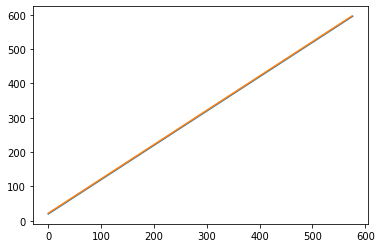

In [16]:
#plt.plot(scipy_signal_full[12:])
plt.plot(scipy_signal_same[11:-12])
plt.plot(scipy_signal_valid)

/home/eric/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


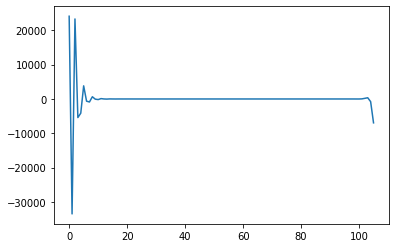

In [69]:
plt.plot(np.fft.ifft(1/np.fft.fft(hrf_signal)))

/home/eric/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


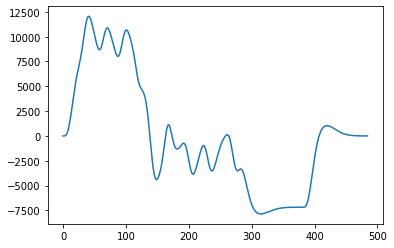

In [70]:
plt.plot(scipy.signal.convolve(scipy_signal_full, np.fft.ifft(1/np.fft.fft(hrf_signal))))

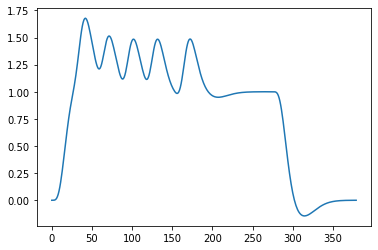

In [71]:
plt.plot(scipy_signal_full)

In [33]:
scipy_signal_full.shape

(291,)

In [ ]:
sig, res = scipy.signal.deconvolve(s[50:150], hrf_signal+1)

plt.plot(sig)

- less numerical problems
- limited signal length by matrix size
- need constant sequence length in data so convolution matrix is reuseable

# Padding Issue

In [ ]:
signal.shape

In [ ]:
import torch as tc
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
sin_signal = np.sin(np.linspace(0, 4*np.pi, 275)) + 1
sin_signal = np.repeat(sin_signal[None, ::], 14, axis=0)
for i in range(2, len(sin_signal)):
    sin_signal[i] *= i
sin_signal = sin_signal[None, ::]
sin_signal.shape
a = np.copy(hrf_signal[::-1])
a = np.repeat(a[None, None, ::], 14, axis=0)

sin_conv = F.conv1d(tc.tensor(sin_signal, dtype=tc.float), tc.tensor(a, dtype=tc.float), padding=25, groups=14)
sin_deconv = F.conv_transpose1d(sin_conv, tc.tensor(a, dtype=tc.float), padding=25, groups=14)
#plt.plot(sin_conv.numpy()[0,0],color='b')
fig = plt.figure(figsize=(15, 9))
plt.plot(sin_deconv.numpy()[0,0],color='r', label="deconvoluted signal")
plt.plot(sin_signal[0,0], label="original signal")
plt.scatter(np.arange(0,25), sin_deconv.numpy()[0,0,0:25])
plt.scatter(np.arange(250,275), sin_deconv.numpy()[0,0,-25::])

plt.legend()

As shown in the image above, the conv_transpose1d is not the exact inversion of conv1d. An exact inversion is possible if the signal length is altered due to padding. These edge points lead to divergences when training the PLRNN because there is a constant, strong MSE loss produced. Hence I choose to remove the edge points which included padding from the MSE calculation. This lead to consistantly better results in the test dataset.

# Deconv 

/home/eric/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/eric/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


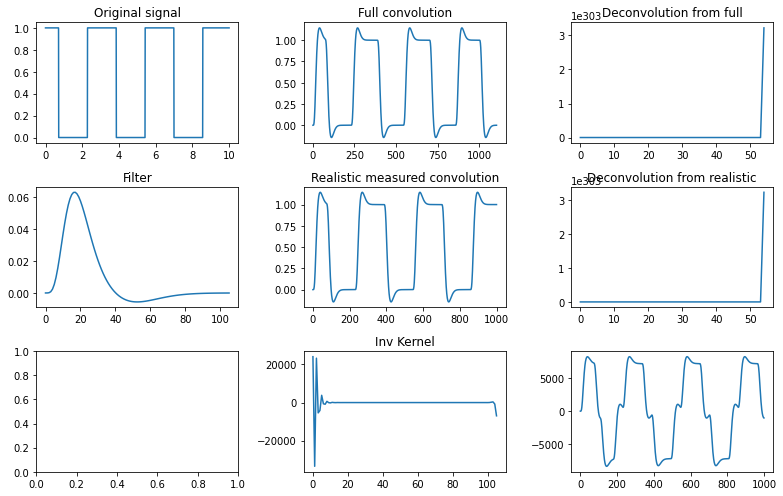

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

# Problem size
T_SIGNAL = 10
T_KERNEL = T_SIGNAL / 2

DT = 0.01
t_signal = np.arange(0, T_SIGNAL + DT, DT)
t_kernel = np.arange(0, T_KERNEL + DT, DT)
t_conv_full = np.arange(0, T_SIGNAL + T_KERNEL + DT, DT)
t_deconv_scipy = np.arange(0, T_SIGNAL - T_KERNEL + DT, DT)
NPOINT = len(t_signal)

# Box Signal
signal = np.zeros(NPOINT)
signal[np.sin(t_signal - 1.5)**2 > 0.5] = 1

# Kernel
TAU = 1.0
kernel = exp_ker(t_kernel, TAU)
kernel /= np.sum(kernel)
kernel = hrf_signal
inv_kernel = np.fft.ifft(1/np.fft.fft(kernel))

# Convolve
sig_conv_full = scipy.signal.convolve(signal, kernel, mode='full')
sig_conv_real = sig_conv_full[:NPOINT]

# Deconvolve
sig_deconv_full, sig_rem_full = scipy.signal.deconvolve(sig_conv_full, kernel)
sig_deconv_real, sig_rem_real = scipy.signal.deconvolve(sig_conv_real, kernel)

sig_deconv_full_2 = scipy.signal.convolve(sig_conv_real, inv_kernel, mode='full')
signal_estimate = sig_deconv_full_2[:NPOINT] #signal trimmed to the required length

fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (11,7), tight_layout=True)
ax[0][0].plot(t_signal, signal)
ax[1][0].plot(kernel)
ax[0][1].plot( sig_conv_full)
ax[1][1].plot(sig_conv_real)
ax[0][2].plot(sig_deconv_full)
ax[1][2].plot(sig_deconv_real)
ax[2][1].plot(inv_kernel)
ax[2][2].plot(signal_estimate)

ax[0][0].set_title("Original signal")
ax[1][0].set_title("Filter")
ax[0][1].set_title("Full convolution")
ax[1][1].set_title("Realistic measured convolution")
ax[0][2].set_title("Deconvolution from full")
ax[1][2].set_title("Deconvolution from realistic")
ax[2][1].set_title("Inv Kernel")

#ax[0][0].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[1][0].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[0][1].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[1][1].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[0][2].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[1][2].set_xlim([0, T_SIGNAL+T_KERNEL])
#ax[2][2].set_xlim([0, T_SIGNAL+T_KERNEL])

#ax[2][2].set_xlim([0, T_SIGNAL+T_KERNEL])

plt.show()

In [58]:
signal

array([1., 1., 1., ..., 1., 1., 1.])

In [46]:
len(hrf_signal)

17

In [52]:
len(t_kernel)

6